# A Low Complexity Three Channel Quantum CNN for Speech Command Recognition

### Display all the commands available

Use the dataset that you trained and quanvolved upon

In [ ]:
!unzip /content/drive/MyDrive/Datasets/speech_commands_v1_10_commands.zip -d .

In [4]:
cd speech_commands_v1_10_commands

/content/speech_commands_v1_10_commands


In [5]:
ls

down/  go/  left/  no/  off/  on/  right/  stop/  up/  yes/


In [6]:
commands = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']

### Choose the Audio File

In [7]:
audio_file = 'stop/012c8314_nohash_0.wav'

### Play the Audio File

In [8]:
import IPython.display as ipd
ipd.Audio(audio_file)

### Compute the spectrogram for the given audio

Here computing log power mel spectrogram as the model is trained on that dataset

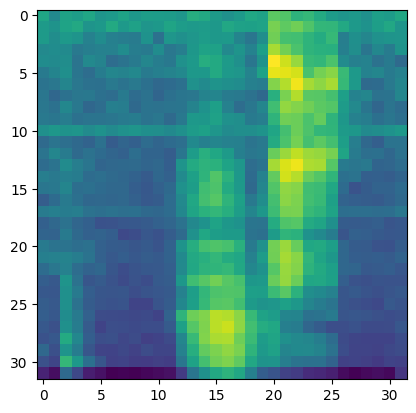

In [13]:
%matplotlib inline
import librosa
import numpy as np
import cv2
from matplotlib import pyplot as plt
sr = 16000
y, _ = librosa.load(audio_file, sr = sr)
if(len(y) == sr):
    mel_feat = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=128, power=1.0, n_mels=60, fmin=40.0, fmax=sr/2)
    log_power_mel_feat = librosa.power_to_db(mel_feat)
    resized_log_power_mel_image = cv2.resize(log_power_mel_feat, (32,32))
    plt.imshow(resized_log_power_mel_image)
    plt.show()

### The Quantum Circuit and QCNN

Run the below cell for 2x2 quanvolution

In [18]:
import pennylane as qml
from pennylane import numpy as qmlnp
from pennylane.templates import RandomLayers

dev = qml.device("default.qubit", wires=4)
n_layers = 1
# Random circuit parameters
# Here, use the parameters you used for quanvolution
rand_params = [[2.97233695, 1.93705856, 3.75475994, 3.3502165]]

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(qmlnp.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = qmlnp.zeros((16, 16, 12))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 32, 2):
        for k in range(0, 32, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results_0 = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )

            q_results_1 = circuit(
                [
                    image[j, k, 1],
                    image[j, k + 1, 1],
                    image[j + 1, k, 1],
                    image[j + 1, k + 1, 1]
                ]
            )

            q_results_2 = circuit(
                [
                    image[j, k, 2],
                    image[j, k + 1, 2],
                    image[j + 1, k, 2],
                    image[j + 1, k + 1, 2]
                ]
            )

            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(0, 4):
                out[j//2, k//2, c] = q_results_0[c]
            for c in range(4, 8):
                out[j//2, k//2, c] = q_results_1[c-4]
            for c in range(8, 12):
                out[j//2, k//2, c] = q_results_2[c-8]
    return out


Run the below cell for 3x3 quanvolution

In [ ]:
import pennylane as qml
from pennylane import numpy as qmlnp
from pennylane.templates import RandomLayers

dev = qml.device("default.qubit", wires=9)
n_layers = 1
# Use the same parameters you used for training
rand_params = [[4.67569424, 1.72307178, 2.95711189, 6.189338, 4.62112322, 2.51773206, 0.05994887, 0.43047562, 0.82051428]]


@qml.qnode(dev)
def circuit(phi):
    # Encoding of 9 classical input values
    for j in range(9):
        qml.RY(qmlnp.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(9)))

    # Measurement producing 9 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(9)]

def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = qmlnp.zeros((11, 11, 27))

    # Loop over the coordinates of the top-left pixel of 3X3 squares. The stride used is 3
    for j in range(0, 32, 3):
        for k in range(0, 32, 3):

            # Prepare the 3x3 region to send to the quantum circuit. Add zero padding when necessary.
            # There are three lists for the three red, green and blue channels of the image.

            q_results_0_list = []
            q_results_1_list = []
            q_results_2_list = []
            for x in range(3):
                for y in range(3):
                    try:
                        q_results_0_list.append(image[j + x, k + y, 0])
                    except:
                        q_results_0_list.append(0)

                    try:
                        q_results_1_list.append(image[j + x, k + y, 1])
                    except:
                        q_results_1_list.append(0)

                    try:
                        q_results_2_list.append(image[j + x, k + y, 2])
                    except:
                        q_results_2_list.append(0)
                    
            # Process a squared 3X3 region of the image with a quantum circuit. Three results for three channels (RGB)
            q_results_0 = circuit(q_results_0_list)
            q_results_1 = circuit(q_results_1_list)
            q_results_2 = circuit(q_results_2_list)
            
            
            # Assign expectation values to different channels of the output pixel (j/3, k/3)
            for c in range(0, 9):
                out[j//3, k//3, c] = q_results_0[c]
            for c in range(9, 18):
                out[j//3, k//3, c] = q_results_1[c-9]
            for c in range(18, 27):
                out[j//3, k//3, c] = q_results_2[c-18]
    return out

### Normalize the image pixels between 0 and 1

In [20]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt


# This is done to account for the changes in colormaps when saving and loading the spectrogram
# We save the spectrograms using matplotlib pyplot and open the dataset directory using tensorflow
# This causes some changes in colormaps and defaults, which we are accounting for here
plt.imsave('/content/latest_recording.png', resized_power_mel_image)
image = tf.keras.utils.load_img('/content/latest_recording.png')


image = np.asarray(image)
final_image = []
for x in image:
    list1 = []
    for y in x:
        list2 = []
        for z in y:
            list2.append(z/255)
        list1.append(list2)
    final_image.append(list1)

final_image = np.asarray(final_image)
print(final_image.shape)

(32, 32, 3)


### Quanvolve the Image

In [21]:
quanvolved_image = quanv(final_image)
print(quanvolved_image.shape)

(16, 16, 12)


### Load the pretrained model

In [22]:
import tensorflow as tf

loaded_model = tf.keras.models.load_model('/content/model_dep.h5')

### Predict the command

In [23]:
prediction = loaded_model.predict(np.expand_dims(quanvolved_image, 0))
print(commands[np.argmax(prediction)])

1/1 [==============================] - 0s 305ms/step
stop
